Cross-League Batting Performance Prediction: Multinomial Logistic Regression for HR/BB/SO/Other

Myungkeun Park

Goal: Show how to use season-level features (age, weight, height, bats, league, position group) to train a multinomial logistic regression that predicts the distribution of plate-appearance outcomes for a player's next season after switching leagues

First, let's prep the data. We need to prepare the following:
- X: features matrix whic has one row per player-season-league consisting of
    1) Numeric Features: 
    > league-specific weight, height, age, age2 (age-squared)
    2) Batting side
    > bats_norm_R, bats_norm_S
    3) League indicator
    > lgID_NL, lgID_CL, lgID_PL, lgID_KBO
    4) Position group
    > pos_group_DPH, pos_group_IF, pos_group_OF

- Y: grouped outcome counts which has one row per player-season-league, four columns with the actual counts of plate-appearance outcomes that year
    > HR, BB, SO, Other
    > PA = SUM(HR, BB, SO, Other)

In [96]:
import pandas as pd

BATTING_PATH = pd.read_csv("mnk_batting.csv")
PEOPLE_PATH = pd.read_csv("merged_player_records.csv")
FIELDING_PATH = pd.read_csv("mnk_fielding.csv")

merged = BATTING_PATH.merge(PEOPLE_PATH, on="playerID", how="inner", suffixes=("", "_ppl"))
display(merged.head(5))


/var/folders/yq/z5fxlp7j2z36sz8z8_q3q00r0000gn/T/ipykernel_89101/2929489754.py:3: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  BATTING_PATH = pd.read_csv("mnk_batting.csv")
/var/folders/yq/z5fxlp7j2z36sz8z8_q3q00r0000gn/T/ipykernel_89101/2929489754.py:5: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  FIELDING_PATH = pd.read_csv("mnk_fielding.csv")


,mnkbID,playerID,mlb_playerID,npb_playerID,kbo_playerID,yearID,stint,lgID,teamID,transition_indicator,...,birthDay,nameLast,nameFirst,nameFull,mlb_weight,npb_weight,kbo_weight,height,bats,throws
0,53,MLB_abadan01_NPB_104799_KBO_,NaN,104799.0,NaN,2000,1,PL,KINTETSU,1,...,25,Abad,Andy,Andy Abad,184,183,184,73,L,L
1,54,MLB_abadan01_NPB_104799_KBO_,abadan01,NaN,NaN,2001,1,AL,OAK,2,...,25,Abad,Andy,Andy Abad,184,183,184,73,L,L
2,55,MLB_abadan01_NPB_104799_KBO_,abadan01,NaN,NaN,2003,1,AL,BOS,2,...,25,Abad,Andy,Andy Abad,184,183,184,73,L,L
3,56,MLB_abadan01_NPB_104799_KBO_,abadan01,NaN,NaN,2006,1,NL,CIN,3,...,25,Abad,Andy,Andy Abad,184,183,184,73,L,L
4,139,MLB_abbotky01_NPB_104266_KBO_,abbotky01,NaN,NaN,1991,1,AL,CAL,1,...,18,Abbott,Kyle,Kyle Abbott,200,201,200,76,L,L


In [97]:
# primary POS per player-year-stint 
fld = FIELDING_PATH.copy()
fld["G"] = pd.to_numeric(fld.get("G", 0), errors="coerce").fillna(0.0)

# retrieve stint-level primary POS, season-level primary POS, career-level primary POS
stint_pos = (
    fld.sort_values(["playerID","yearID","stint","G"], ascending=[True,True,True,False])
       .drop_duplicates(["playerID","yearID","stint"])
       [["playerID","yearID","stint","POS"]]
       .rename(columns={"POS":"POS_stint"}))

season_pos = (
    fld.groupby(["playerID","yearID","lgID","POS"], as_index=False)["G"].sum()
       .sort_values(["playerID","yearID","lgID","G"], ascending=[True,True,True,False])
       .drop_duplicates(["playerID","yearID","lgID"])
       [["playerID","yearID","lgID","POS"]]
       .rename(columns={"POS":"POS_season"}))

career_pos = (
    fld.groupby(["playerID","POS"], as_index=False)["G"].sum()
       .sort_values(["playerID","G"], ascending=[True,False])
       .drop_duplicates(["playerID"])
       [["playerID","POS"]]
       .rename(columns={"POS":"POS_career"}))

merged = (
    merged.sort_values(["playerID","yearID","stint"])
          .merge(stint_pos, on=["playerID","yearID","stint"], how="left")
          .merge(season_pos, on=["playerID","yearID","lgID"], how="left")
          .merge(career_pos, on="playerID", how="left"))

merged["POS_primary"] = merged["POS_stint"]
merged["POS_primary"] = merged["POS_primary"].fillna(merged["POS_season"])
merged["POS_primary"] = merged["POS_primary"].fillna(merged["POS_career"])

pos_missing = int(merged["POS_primary"].isna().sum())
print(pos_missing)
display(merged[["playerID","yearID","stint","lgID","teamID","POS_primary"]].head(20))

0


,playerID,yearID,stint,lgID,teamID,POS_primary
0,MLB__NPB_102080_KBO_96480,1963,1,PL,TOEI,C
1,MLB__NPB_102080_KBO_96480,1964,1,PL,TOEI,C
2,MLB__NPB_102080_KBO_96480,1965,1,PL,TOEI,C
3,MLB__NPB_102080_KBO_96480,1966,1,PL,TOEI,OF
4,MLB__NPB_102080_KBO_96480,1967,1,PL,TOEI,OF
5,MLB__NPB_102080_KBO_96480,1968,1,PL,TOEI,OF
6,MLB__NPB_102080_KBO_96480,1969,1,PL,TOEI,OF
7,MLB__NPB_102080_KBO_96480,1970,1,PL,TOEI,OF
8,MLB__NPB_102080_KBO_96480,1971,1,PL,TOEI,OF
9,MLB__NPB_102080_KBO_96480,1972,1,PL,TOEI,OF


In [98]:
import numpy as np

# age, weight, bats, pos (with DH/PH rules)

# age
merged["age"] = (merged["yearID"] - merged["birthYear"]).astype(float)

# league-specific weight
for weight in ["mlb_weight","npb_weight","kbo_weight"]:
    if weight not in merged.columns:
        merged[weight] = np.nan

def choose_weight(row):
    lg = row["lgID"]
    w_mlb = row.get("mlb_weight", np.nan)
    w_npb = row.get("npb_weight", np.nan)
    w_kbo = row.get("kbo_weight", np.nan)
    mapping = {"AL": w_mlb, "NL": w_mlb, "CL": w_npb, "PL": w_npb, "KBO": w_kbo}
    pick = mapping.get(lg, np.nan)
    if pd.notna(pick) and pick != 0:
        return pick
    for v in (w_mlb, w_npb, w_kbo):
        if pd.notna(v) and v != 0:
            return v
    return np.nan

merged["weight"] = merged.apply(choose_weight, axis=1)

# normalize bats B -> S
bats = merged.get("bats", pd.Series(index=merged.index, dtype=object)).astype(str).str.upper()
bats = bats.replace({"B":"S", "NAN":np.nan}).fillna("U")
merged["bats_norm"] = bats

# POS final fill:
#   AL: DH since 1973
#   NL: DH since 2022
#   PL: DH since 1975
#   CL: no DH so PH
#   KBO: DH used
if pos_missing != 0:
    POS_primary = merged["POS_primary"].copy()
    mask_na = POS_primary.isna()
    dh_AL = (merged["lgID"].eq("AL") & (merged["yearID"] >= 1973))
    dh_NL = (merged["lgID"].eq("NL") & (merged["yearID"] >= 2022))
    dh_PL = (merged["lgID"].eq("PL") & (merged["yearID"] >= 1975))
    dh_KBO = (merged["lgID"].eq("KBO"))
    mask_dh = mask_na & (dh_AL | dh_NL | dh_PL | dh_KBO)

    # fill DH where DH leagues apply, else PH
    POS_primary = POS_primary.where(~mask_dh, "DH")
    POS_primary = POS_primary.fillna("PH")
    merged["POS_primary"] = POS_primary
    
display(merged[["playerID","yearID","lgID","age","height","weight","bats_norm","POS_primary"]].head(20))

,playerID,yearID,lgID,age,height,weight,bats_norm,POS_primary
0,MLB__NPB_102080_KBO_96480,1963,PL,20.0,69,181,R,C
1,MLB__NPB_102080_KBO_96480,1964,PL,21.0,69,181,R,C
2,MLB__NPB_102080_KBO_96480,1965,PL,22.0,69,181,R,C
3,MLB__NPB_102080_KBO_96480,1966,PL,23.0,69,181,R,OF
4,MLB__NPB_102080_KBO_96480,1967,PL,24.0,69,181,R,OF
5,MLB__NPB_102080_KBO_96480,1968,PL,25.0,69,181,R,OF
6,MLB__NPB_102080_KBO_96480,1969,PL,26.0,69,181,R,OF
7,MLB__NPB_102080_KBO_96480,1970,PL,27.0,69,181,R,OF
8,MLB__NPB_102080_KBO_96480,1971,PL,28.0,69,181,R,OF
9,MLB__NPB_102080_KBO_96480,1972,PL,29.0,69,181,R,OF


In [99]:
# Build PA at row level; prefer provided PA, else AB+BB+HBP+SH+SF
df = merged.copy()

# Ensure HR/BB/SO/AB/HBP/SH/SF are numeric
if "PA" in df.columns:
    df["PA_row"] = pd.to_numeric(df["PA"], errors="coerce")
else:
    # ONLY build from stats if they actually exist
    comp_cols = [c for c in ["AB","BB","HBP","SH","SF"] if c in df.columns]
    if comp_cols:
        for c in comp_cols:
            df[c] = pd.to_numeric(df[c], errors="coerce")
        df["PA_row"] = df[comp_cols].sum(axis=1, min_count=1)
    else:
        df["PA_row"] = np.nan

# no 'Other' yet
row_outcomes = df[["playerID","yearID","lgID","HR","BB","SO","PA_row"]].copy()
row_outcomes.rename(columns={"PA_row":"PA"}, inplace=True)

display(row_outcomes.head(10))


,playerID,yearID,lgID,HR,BB,SO,PA
0,MLB__NPB_102080_KBO_96480,1963,PL,0,0,4.0,19.0
1,MLB__NPB_102080_KBO_96480,1964,PL,6,8,34.0,264.0
2,MLB__NPB_102080_KBO_96480,1965,PL,14,11,28.0,378.0
3,MLB__NPB_102080_KBO_96480,1966,PL,4,12,30.0,382.0
4,MLB__NPB_102080_KBO_96480,1967,PL,10,15,24.0,431.0
5,MLB__NPB_102080_KBO_96480,1968,PL,15,9,21.0,397.0
6,MLB__NPB_102080_KBO_96480,1969,PL,12,13,31.0,472.0
7,MLB__NPB_102080_KBO_96480,1970,PL,18,36,39.0,540.0
8,MLB__NPB_102080_KBO_96480,1971,PL,11,26,37.0,448.0
9,MLB__NPB_102080_KBO_96480,1972,PL,19,35,32.0,529.0


In [100]:
agg_y = (row_outcomes
         .groupby(["playerID","yearID","lgID"], as_index=False)
         .agg(PA=("PA","sum"), HR=("HR","sum"), BB=("BB","sum"), SO=("SO","sum")))

merged["pos"] = merged["POS_primary"]

# season-level predictors 
tmp = merged[["playerID","yearID","lgID","pos","bats_norm","height","weight","age"]].copy()
agg_num = (tmp.groupby(["playerID","yearID","lgID"], as_index=False).agg(height=("height","mean"), weight=("weight","mean"), age=("age","mean")))
mode_fn = lambda s: s.mode(dropna=True).iat[0] if not s.mode(dropna=True).empty else np.nan
agg_cat = (tmp.groupby(["playerID","yearID","lgID"], as_index=False).agg(bats_norm=("bats_norm", mode_fn), pos=("pos", mode_fn)))

# combine outcomes + predictors
combo = (agg_y.merge(agg_num, on=["playerID","yearID","lgID"], how="left").merge(agg_cat, on=["playerID","yearID","lgID"], how="left"))

# compute Other from season totals so PA == HR+BB+SO+Other
for c in ["PA","HR","BB","SO"]:
    combo[c] = pd.to_numeric(combo[c], errors="coerce").fillna(0.0)

combo["Other"] = (combo["PA"] - combo["HR"] - combo["BB"] - combo["SO"]).astype(float)
combo.loc[combo["Other"] < 0, "Other"] = 0.0

# combo = combo[combo["pos"] != "P"].reset_index(drop=True)

sum_check = np.isclose(
    combo[["HR","BB","SO","Other"]].sum(axis=1).to_numpy(),
    combo["PA"].to_numpy())

print(int((~sum_check).sum()))
display(combo[["playerID","yearID","lgID","PA","HR","BB","SO","Other"]].head(200))

30


,playerID,yearID,lgID,PA,HR,BB,SO,Other
0,MLB__NPB_102080_KBO_96480,1963,PL,19.0,0,0,4.0,15.0
1,MLB__NPB_102080_KBO_96480,1964,PL,264.0,6,8,34.0,216.0
2,MLB__NPB_102080_KBO_96480,1965,PL,378.0,14,11,28.0,325.0
3,MLB__NPB_102080_KBO_96480,1966,PL,382.0,4,12,30.0,336.0
4,MLB__NPB_102080_KBO_96480,1967,PL,431.0,10,15,24.0,382.0
...,...,...,...,...,...,...,...,...
195,MLB__NPB_103809_KBO_94408,2000,KBO,14.0,0,1,2.0,11.0
196,MLB__NPB_103970_KBO_73229,1990,PL,0.0,0,0,0.0,0.0
197,MLB__NPB_103970_KBO_73229,1991,PL,0.0,0,0,0.0,0.0
198,MLB__NPB_103970_KBO_73229,1992,PL,0.0,0,0,0.0,0.0


Since SUM(HR, BB, SO, Other) == PA, manual edits have been applied

In [101]:
diff = combo["PA"] - (combo["HR"] + combo["BB"] + combo["SO"])
print("rows with PA < HR+BB+SO = ", int((diff < 0).sum()))
print("rows with PA > HR+BB+SO = ", int((diff > 0).sum()))
display(combo.loc[diff < 0, ["playerID","yearID","lgID","PA","HR","BB","SO"]].head(10))

rows with PA < HR+BB+SO =  30
rows with PA > HR+BB+SO =  8361


,playerID,yearID,lgID,PA,HR,BB,SO
1090,MLB_baumeji01_NPB_102035_KBO_,1949,AL,0.0,0,2,1.0
1205,MLB_bertore01_NPB_102110_KBO_,1953,AL,0.0,0,0,1.0
2876,MLB_dobyla01_NPB_101920_KBO_,1947,AL,0.0,0,1,11.0
2877,MLB_dobyla01_NPB_101920_KBO_,1948,AL,0.0,14,54,77.0
2878,MLB_dobyla01_NPB_101920_KBO_,1949,AL,0.0,24,91,90.0
2879,MLB_dobyla01_NPB_101920_KBO_,1950,AL,0.0,25,98,71.0
2880,MLB_dobyla01_NPB_101920_KBO_,1951,AL,0.0,20,101,81.0
2881,MLB_dobyla01_NPB_101920_KBO_,1952,AL,0.0,32,90,111.0
2882,MLB_dobyla01_NPB_101920_KBO_,1953,AL,0.0,29,96,121.0
3353,MLB_foytapa01_NPB_102189_KBO_,1953,AL,0.0,0,0,1.0


In [102]:
# fix PA value 
# If PA >= HR+BB+SO then set Other = PA − (HR+BB+SO)
# If PA < HR+BB+SO or PA is NaN then set PA = HR+BB+SO and Other = 0

for c in ["PA","HR","BB","SO"]:
    combo[c] = pd.to_numeric(combo[c], errors="coerce")

sum_outcomes = combo[["HR","BB","SO"]].sum(axis=1)
diff = combo["PA"] - sum_outcomes

# Rows to fix: PA is NaN or PA < HR+BB+SO
fix = combo["PA"].isna() | (diff < 0)

combo.loc[fix, "PA"] = sum_outcomes[fix].astype(float)

# compute Other from (possibly updated) PA
combo["Other"] = (combo["PA"] - sum_outcomes).clip(lower=0).astype(float)

In [103]:

sum_check = np.isclose(
    combo[["HR","BB","SO","Other"]].sum(axis=1).to_numpy(),
    combo["PA"].to_numpy())

print(int((~sum_check).sum()))

# if 0, we are good to go

0


In [104]:
# Build X
# age2 
combo["age2"] = combo["age"] ** 2

# position groups (C baseline; keep DPH/IF/OF dummies)
def pos_group_fn(p):
    if p == "C":
        return "C"
    if p in ("1B","2B","SS","3B"):
        return "IF"
    if p == "OF":
        return "OF"
    if p == "P":
        return "P"
    if p in ("DH","PH"):
        return "DPH"
    return "C"

if "pos_group" not in combo.columns:
    combo["pos_group"] = combo["pos"].map(pos_group_fn)

# z-score ((x1 - mean) / std) for weight, height, age, age2
X_num = combo[["weight","height","age","age2"]].astype(float)
X_num = (X_num - X_num.mean()) / X_num.std(ddof=0)

combo["bats_norm"] = pd.Categorical(combo["bats_norm"].fillna("U"), categories=["L","R","S","U"], ordered=False)

# prefer MLB baselines if present
preferred_lg_order = ["AL","NL","CL","PL","KBO","FL","JBL","UA","UPL"]
present = [lg for lg in preferred_lg_order if lg in set(combo["lgID"].dropna())]
others = [lg for lg in combo["lgID"].dropna().unique() if lg not in present]
lg_levels = present + list(others) if present else sorted(combo["lgID"].dropna().unique().tolist())
combo["lgID"] = pd.Categorical(combo["lgID"], categories=lg_levels, ordered=False)

combo["pos_group"] = pd.Categorical(
    combo["pos_group"],
    categories=["C","DPH","IF","OF"],
    ordered=False)

# factor dummies with one level dropped per factor
X_cat = pd.get_dummies(combo[["bats_norm","lgID","pos_group"]],drop_first=True)
if "bats_norm_U" in X_cat.columns:
    X_cat = X_cat.drop(columns=["bats_norm_U"])
# Final X = scaled numeric + factor dummies
X_df = pd.concat([X_num, X_cat], axis=1)

X_columns = X_df.columns.tolist()
display(X_df.head(20))


,weight,height,age,age2,bats_norm_R,bats_norm_S,lgID_NL,lgID_CL,lgID_PL,lgID_KBO,pos_group_DPH,pos_group_IF,pos_group_OF
0,-0.854643,-1.908455,-2.127221,-1.810067,True,False,False,False,True,False,False,False,False
1,-0.854643,-1.908455,-1.888178,-1.646115,True,False,False,False,True,False,False,False,False
2,-0.854643,-1.908455,-1.649136,-1.474165,True,False,False,False,True,False,False,False,False
3,-0.854643,-1.908455,-1.410094,-1.294217,True,False,False,False,True,False,False,False,True
4,-0.854643,-1.908455,-1.171051,-1.106272,True,False,False,False,True,False,False,False,True
5,-0.854643,-1.908455,-0.932009,-0.910329,True,False,False,False,True,False,False,False,True
6,-0.854643,-1.908455,-0.692967,-0.706389,True,False,False,False,True,False,False,False,True
7,-0.854643,-1.908455,-0.453924,-0.494450,True,False,False,False,True,False,False,False,True
8,-0.854643,-1.908455,-0.214882,-0.274514,True,False,False,False,True,False,False,False,True
9,-0.854643,-1.908455,0.024160,-0.046581,True,False,False,False,True,False,False,False,True


In [105]:
# Build Y: outcome matrix (HR, BB, SO, Other)
Y = combo[["HR","BB","SO","Other"]].to_numpy(dtype=np.float64)
PA_out = combo["PA"].to_numpy(dtype=np.float64)

Quick length, sum and non-negative tests performed on Y

In [106]:
len_check = (Y.shape[0] == PA_out.shape[0])
sum_check2 = np.allclose(Y.sum(axis=1), PA_out, atol=1e-8)
non_neg_check = np.all((Y >= 0).ravel()) and np.all(PA_out >= 0)

print(len_check)
print(sum_check2)
print(non_neg_check)

True
True
True


In [107]:
display(Y[:20])
PA_out

array([[  0.,   0.,   4.,  15.],
       [  6.,   8.,  34., 216.],
       [ 14.,  11.,  28., 325.],
       [  4.,  12.,  30., 336.],
       [ 10.,  15.,  24., 382.],
       [ 15.,   9.,  21., 352.],
       [ 12.,  13.,  31., 416.],
       [ 18.,  36.,  39., 447.],
       [ 11.,  26.,  37., 374.],
       [ 19.,  35.,  32., 443.],
       [  6.,  16.,  22., 268.],
       [ 15.,  22.,  19., 401.],
       [ 16.,  17.,  18., 352.],
       [ 17.,  23.,  33., 425.],
       [ 16.,  30.,  33., 411.],
       [  3.,   7.,  12., 159.],
       [ 18.,  21.,  25., 379.],
       [  5.,   7.,  17., 153.],
       [  4.,  14.,  12., 184.],
       [ 19.,  42.,  17., 214.]])

array([ 19., 264., 378., ..., 532., 326., 263.])

In [108]:
# combo, X_df from data prep stage above
combo = combo.reset_index(drop=True)
X_df = X_df.reset_index(drop=True)

# order/columns to match with Y (outcome matrix)
class_names = ["HR", "BB", "SO", "Other"]
if Y.shape[1] == len(class_names):
    print("Good to go")

Good to go


Now, let's identify cross-league targets. We define "targets" as the rows for year T where the player also played year T-1 + the league changed from T-1 ---> T

In [109]:
ids = combo[["playerID","yearID","lgID"]].copy()
ids["row"] = ids.index
ids = ids.sort_values(["playerID","yearID"])

# previous year/league (within each player)
ids["prev_year"] = ids.groupby("playerID")["yearID"].shift(1)
ids["prev_lg"] = ids.groupby("playerID")["lgID"].shift(1)

# target rows: consecutive seasons AND league changed
targets = ids[(ids["prev_year"] == ids["yearID"] - 1) & (ids["lgID"] != ids["prev_lg"])].copy()

len(targets) # saving these
display(targets.head(10)[["row","playerID","prev_year","prev_lg","yearID","lgID"]])

,row,playerID,prev_year,prev_lg,yearID,lgID
19,19,MLB__NPB_102080_KBO_96480,1981.0,PL,1982,KBO
26,26,MLB__NPB_102608_KBO_83999,1972.0,CL,1973,PL
30,30,MLB__NPB_102608_KBO_83999,1976.0,PL,1977,CL
54,54,MLB__NPB_102687_KBO_84999,1991.0,CL,1992,PL
60,60,MLB__NPB_102771_KBO_86303,1976.0,CL,1977,PL
68,68,MLB__NPB_102771_KBO_86303,1984.0,PL,1985,CL
79,79,MLB__NPB_102864_KBO_80057,1983.0,PL,1984,KBO
86,86,MLB__NPB_102893_KBO_83800,1982.0,CL,1983,KBO
96,96,MLB__NPB_103035_KBO_84573,1983.0,PL,1984,KBO
108,108,MLB__NPB_103094_KBO_88274,1982.0,PL,1983,CL


Divide rows to train + to target

In [110]:
# indices for saved rows (yr+1 different league)
target_idx = targets["row"].to_numpy()
train_mask = ~combo.index.isin(target_idx)

# train arrays
X_train = X_df.loc[train_mask].to_numpy(dtype=float)
Y_train = Y[train_mask, :]

# target arrays (to be predicted)
X_tgt = X_df.loc[target_idx].to_numpy(dtype=float)
Y_tgt = Y[target_idx, :]
PA_tgt = PA_out[target_idx]

print("Train rows:", X_train.shape[0])
print("Target rows:", X_tgt.shape[0])

Train rows: 9524
Target rows: 2052


Further transform the data to meet scikit-learn requirement


In [111]:
from sklearn.linear_model import LogisticRegression

def build_long(X_mat, Y_counts):
    """
    returns:
    - X_long : repeated feature rows (N*J, p)
    - y_long : class labels 0..J-1 (length N*J)
    - w_long : sample weights = counts (length N*J)
    *keep : drop zero-weight rows; contribute nothing to the likelihood
    """
    N, p = X_mat.shape
    J = Y_counts.shape[1]
    y_long = np.tile(np.arange(J, dtype=int), N)
    w_long = Y_counts.reshape(-1).astype(float)
    X_long = np.repeat(X_mat, J, axis=0) 

    keep = w_long > 0
    return X_long[keep], y_long[keep], w_long[keep]

X_long_tr, y_long_tr, w_long_tr = build_long(X_train, Y_train)

In [112]:
# perform quick check on required dimensions
assert X_long_tr.ndim == 2, "X_long_tr needs to be 2D"
assert y_long_tr.ndim == 1, "y_long_tr needs to be 1D"
assert w_long_tr.ndim == 1, "w_long_tr needs to be 1D"
assert len(y_long_tr) == len(w_long_tr) == X_long_tr.shape[0], "must align"

Fit the model

In [113]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    penalty="l2",                  # adds rigdge regularization
    C=1e6,                         # inverse regularization strength     
    max_iter=5000                  # times to converge
)

# perform optimization, using counts as frequency weights
clf.fit(X_long_tr, y_long_tr, sample_weight=w_long_tr)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(C=1000000.0, max_iter=5000, multi_class='multinomial')

In [114]:
# Predict the target rows (YR+1 in new league)
# proba_tgt[i, j] = predicted probability of class j for target row i
# Expected counts = probabilities * PA for that target row

# predict class probabilities for each target row
proba_tgt = clf.predict_proba(X_tgt)

# Convert probabilities to expected counts
Yhat_tgt  = proba_tgt * PA_tgt[:, None]

# predicted probabilities (each row should sum to around 1)
proba_cols = [class_names[i] for i in clf.classes_]
proba_df = pd.DataFrame(proba_tgt, columns=proba_cols)
display(proba_df.head(10))
row_sums = proba_tgt.sum(axis=1)
print("probability of rows sum (min/mean/max):", float(row_sums.min()), float(row_sums.mean()), float(row_sums.max()))


,HR,BB,SO,Other
0,0.026289,0.092504,0.114656,0.766551
1,0.017881,0.045806,0.281154,0.655158
2,0.019652,0.046459,0.294021,0.639868
3,0.014788,0.056696,0.240206,0.688310
4,0.014983,0.045465,0.223369,0.716183
5,0.016154,0.046872,0.235545,0.701428
6,0.012651,0.055470,0.177731,0.754148
7,0.016724,0.056449,0.228930,0.697896
8,0.028587,0.105171,0.107763,0.758479
9,0.035468,0.076504,0.149266,0.738762


probability of rows sum (min/mean/max): 0.9999999999999998 1.0 1.0000000000000002


Build actual vs predicted counts table

In [115]:
# build actual vs predicted counts table
preview = pd.DataFrame({
    "playerID": combo.loc[target_idx, "playerID"].to_numpy(),
    "prev_year": targets["prev_year"].to_numpy(),
    "prev_lg": targets["prev_lg"].to_numpy(),
    "yearID": combo.loc[target_idx, "yearID"].to_numpy(),
    "lgID": combo.loc[target_idx, "lgID"].to_numpy(),
    "PA": PA_tgt,
})

for j, nm in enumerate(proba_cols):
    preview[f"act_{nm}"] = Y_tgt[:, j]
    preview[f"pred_{nm}"] = Yhat_tgt[:, j]

display(preview.head(40))


,playerID,prev_year,prev_lg,yearID,lgID,PA,act_HR,pred_HR,act_BB,pred_BB,act_SO,pred_SO,act_Other,pred_Other
0,MLB__NPB_102080_KBO_96480,1981.0,PL,1982,KBO,292.0,19.0,7.676505,42.0,27.011199,17.0,33.479457,214.0,223.832838
1,MLB__NPB_102608_KBO_83999,1972.0,CL,1973,PL,48.0,0.0,0.858287,1.0,2.198708,20.0,13.495404,27.0,31.447601
2,MLB__NPB_102608_KBO_83999,1976.0,PL,1977,CL,20.0,0.0,0.393042,0.0,0.929188,8.0,5.880415,12.0,12.797355
3,MLB__NPB_102687_KBO_84999,1991.0,CL,1992,PL,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
4,MLB__NPB_102771_KBO_86303,1976.0,CL,1977,PL,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
5,MLB__NPB_102771_KBO_86303,1984.0,PL,1985,CL,1.0,0.0,0.016154,0.0,0.046872,1.0,0.235545,0.0,0.701428
6,MLB__NPB_102864_KBO_80057,1983.0,PL,1984,KBO,141.0,2.0,1.783773,4.0,7.821251,22.0,25.060083,113.0,106.334893
7,MLB__NPB_102893_KBO_83800,1982.0,CL,1983,KBO,329.0,12.0,5.502233,20.0,18.571857,35.0,75.318027,262.0,229.607884
8,MLB__NPB_103035_KBO_84573,1983.0,PL,1984,KBO,403.0,11.0,11.520437,43.0,42.384057,36.0,43.428363,313.0,305.667143
9,MLB__NPB_103094_KBO_88274,1982.0,PL,1983,CL,13.0,0.0,0.461084,1.0,0.994547,1.0,1.940463,11.0,9.603906


Draw scatter plots with a baseline:
- Above the line = actual > predicted = model under-predicts
- Below the line = actual < predicted = model over-predicts

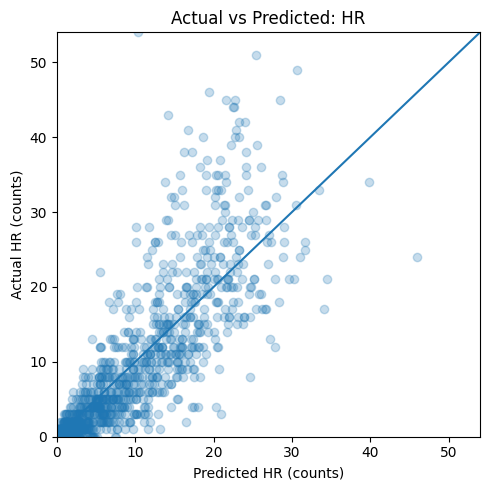

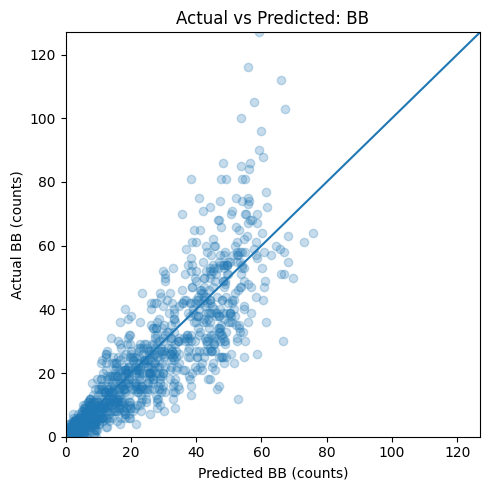

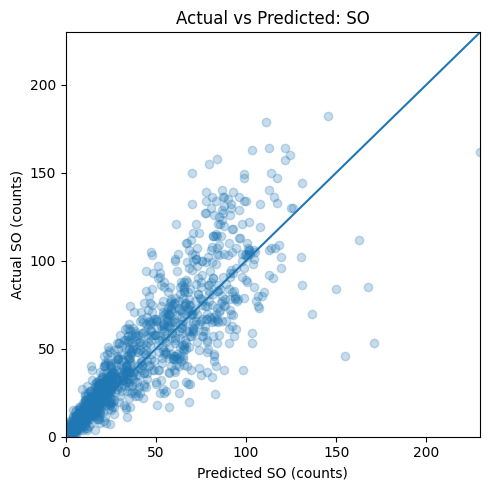

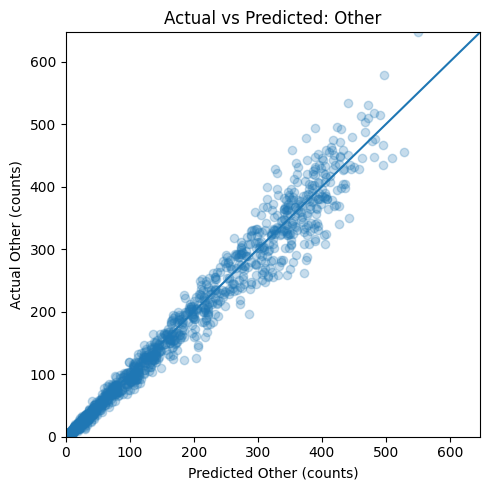

In [116]:
# scatter plot on actual vs predicted counts (per outcome)

import matplotlib.pyplot as plt

def scatter_act_pred(df, metric, alpha=0.25):
    x = df[f"pred_{metric}"].to_numpy()
    y = df[f"act_{metric}"].to_numpy()
    m = max(1.0, np.nanmax(np.concatenate([x, y])))
    plt.figure(figsize=(5,5))
    plt.plot([0, m], [0, m]) # y = x reference
    plt.scatter(x, y, alpha=alpha)
    plt.xlabel(f"Predicted {metric} (counts)")
    plt.ylabel(f"Actual {metric} (counts)")
    plt.title(f"Actual vs Predicted: {metric}")
    plt.xlim(0, m); plt.ylim(0, m)
    plt.tight_layout()
    plt.show()

for metric in proba_cols:
    scatter_act_pred(preview, metric)


Generated a table to see which transition / stat was underpredicted or overpredicted

In [117]:
cols = ["HR","BB","SO","Other"]

def league_group(lg):
    if lg in ("AL","NL"): return "MLB"
    if lg in ("CL","PL"): return "NPB"
    return "KBO"

df = preview.copy()
df = df[df["PA"] > 0].reset_index(drop=True)
df["src_group"] = df["prev_lg"].map(league_group)
df["dst_group"] = df["lgID"].map(league_group)
df = df[df["src_group"].notna() & df["dst_group"].notna() & (df["src_group"] != df["dst_group"])].reset_index(drop=True)
df["switch_type"] = df["src_group"] + "→" + df["dst_group"]

rows = []
for st, g in df.groupby("switch_type", sort=False):
    out = {"switch_type": st, "n_rows": int(len(g))}
    for c in cols:
        diff = (g[f"act_{c}"] - g[f"pred_{c}"]).to_numpy(float)
        out[f"{c}_above"] = int((diff > 0).sum())  # actual > predicted
        out[f"{c}_below"] = int((diff < 0).sum())  # actual < predicted
    rows.append(out)

switch_order = ["MLB→NPB","MLB→KBO","NPB→MLB","NPB→KBO","KBO→MLB","KBO→NPB"]
ab_bl = pd.DataFrame(rows).set_index("switch_type").reindex(switch_order)

display(ab_bl)


,n_rows,HR_above,HR_below,BB_above,BB_below,SO_above,SO_below,Other_above,Other_below
switch_type,,,,,,,,,
MLB→NPB,558,156,402,192,366,382,176,217,341
MLB→KBO,75,31,44,24,51,50,25,33,42
NPB→MLB,149,39,110,42,107,90,59,62,87
NPB→KBO,29,13,16,12,17,14,15,16,13
KBO→MLB,26,10,16,12,14,20,6,7,19
KBO→NPB,18,3,15,10,8,14,4,6,12


Overall pattern across all 6 transitions:
The model tends to under-predicts strikeouts. Every transition shows more SO "above" than "below" except for the NPB->KBO transition. The model tends to over-predict HR and BB. Most transition have more "below" than "above" for HR and BB.

- MLB -> NPB: SO under-predicted; HR/BB/Other over-predicted
- MLB -> KBO: Same direction as MLB -> NPB though milder, SO under-predicted
- NPB -> MLB: Same pattern; moving into MLB, the model still under-predicts SO and over-predicts HR/BB/Other
- NPB -> KBO: Mixed but broadly similar; SO near-balanced, mild HR/BB over-prediction, Other slightly under-predicted
- KBO -> MLB: Clear SO under-prediction; HR/BB/Other mostly over-predicted
- KBO -> NPB: Strong SO under-prediction and HR/Other over-prediction; BB slightly under-predicted

The multinomial model gets the broad pattern right, however, 5 out of 6 transitions have actual SO above predicted SO which shows us that the model is predicting too few strikeouts after league switches. As a result, too many HR/BB/Other (since the sum of the probabilities must equal to 1). This looks like an issue where predicted probabilities don't match what actually happens. 